Focusing on fixing relative errors, which get really large when flux is very low.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dataDIR = 'short'
DS = xr.open_dataset(dataDIR)

In [3]:
#Temperature:
T = (DS.T.values + DS.T0) * ((DS.P.values + DS.PB.values)/DS.P0)**(DS.R_D/DS.CP)

In [4]:
T.shape #days, height, latitude, longtitude

(240, 52, 36, 72)

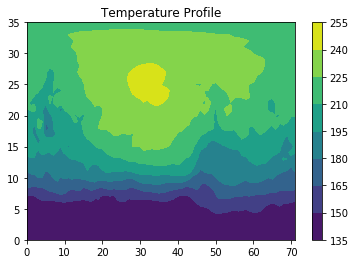

In [5]:
example_data = T[50,5,:, :]
plt.contourf(example_data)
plt.colorbar()
plt.title("Temperature Profile")
plt.show()

In [6]:
albedo = DS.ALBEDO.values

In [7]:
albedo.shape #days, latitude, longtitude

(240, 36, 72)

In [8]:
st = DS.TSK.values

In [9]:
st.shape

(240, 36, 72)

In [10]:
d_c = DS.TAU_OD.values

In [11]:
d_c.shape 

(240, 52, 36, 72)

In [12]:
tsf = DS.TOASW.values #top solar flux

In [13]:
tsf.shape

(240, 36, 72)

In [14]:
albedo = DS.ALBEDO.values

In [15]:
bsf = DS.GSW.values #bottom solar flux, ouput

In [16]:
bsf2 = bsf/(1-albedo)

In [17]:
bsf.shape

(240, 36, 72)

Let's combine the data together for ten time samples, with full latitude and longitude:

In [18]:
e_t = [] #equator input and output
#input:
for k in range(10): #10 days
    for i in range(36):
        for j in range(72):
            input_array = list(T[k,:,i,j]) #start with temp profile
            input_array+=list(d_c[k,:,i,j]) #add dust profile
            input_array.append(st[k,i,j])#add surface temp
            input_array.append(tsf[k,i,j]) #add top solar flux, without the albedo factor
            input_array.append(bsf2[k,i,j])            
            e_t.append(input_array) #appends input to input array

In [19]:
e_t = np.array(e_t)
e_t.shape

(25920, 107)

In [20]:
e_d = pd.DataFrame(e_t) 

Split up the data:

In [21]:
e_d = e_d[e_d.iloc[:,105] != 0] #remove 0 flux, could later use a simple classifier to determine which data has 0 bottom flux...
e_reml = e_d[e_d.iloc[:,105] > 20] #large flux data, greater than 10% of the average
e_rems = e_d[e_d.iloc[:,105] < 20] #small flux data, greater than 10% of the average

Train two linear regressors, one for the large flux data and the other for small flux data:

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

train_set, test_set = train_test_split(e_reml, test_size=0.2, random_state=42)

train_in = train_set.iloc[:,:106] #training input
train_out = train_set.iloc[:,106] #training output
test_in = test_set.iloc[:,:106] #testing input 
test_out = test_set.iloc[:,106] #testing output

w = 1/train_out**2
lrl = LinearRegression() #linear regression for large flux data
lrl.fit(train_in,train_out, sample_weight=w)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
train_set, test_set = train_test_split(e_rems, test_size=0.2, random_state=42)

train_in = train_set.iloc[:,:106] #training input
train_out = train_set.iloc[:,106] #training output
test_in = test_set.iloc[:,:106] #testing input
test_out = test_set.iloc[:,106] #testing output

w = 1/train_out**2
lrs = LinearRegression() #linear regression for small flux data
lrs.fit(train_in,train_out, sample_weight=w)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

A custom predictor which can handle all the data:

In [24]:
def clp(in_data): #custom linear predictor
    in_data = np.array(in_data)
    out_data = []
    for instance in in_data:
        if instance[105] > 20:
            out_data.append(float(lrl.predict(instance[:106].reshape(1,-1)))) #uses large flux predictor 
        else:
            out_data.append(float(lrs.predict(instance[:106].reshape(1,-1)))) #uses small flux predictor
    return np.array(out_data)

In [25]:
total_in = e_d.iloc[:,:106] #total input
total_out = e_d.iloc[:,106] #total output

In [26]:
total_pred = clp(total_in)

In [27]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(total_out, total_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse  

7.81570326207733

Plotting data:

In [28]:
all_indices = total_in.index
ti_indices = all_indices[all_indices > 5*36*72] 
ti_indices = ti_indices[ti_indices < 6 *36*72] 
ti_indices #ith time snapshot indices for latitude/longtitude map, currently set to 6th time snapshot

Int64Index([13351, 13352, 13353, 13354, 13355, 13356, 13357, 13358, 13359,
            13360,
            ...
            15542, 15543, 15544, 15545, 15546, 15547, 15548, 15549, 15550,
            15551],
           dtype='int64', length=1320)

In [29]:
total_out = np.array(total_out)
full_out_contour = np.full((36, 72), np.nan)
full_pred_contour = np.full((36, 72), np.nan)
for index in ti_indices:
    lat_point = index//72 - 36*5
    long_point = index%72 - 1*72
    full_out_contour[lat_point][long_point] = total_out[np.where(all_indices == index)]
    full_pred_contour[lat_point][long_point] = total_pred[np.where(all_indices == index)]

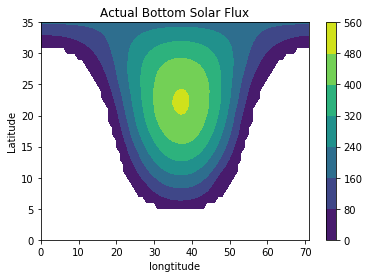

<Figure size 432x288 with 0 Axes>

In [30]:
plt.contourf(full_out_contour)
plt.colorbar()
plt.title("Actual Bottom Solar Flux")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig("Actual")

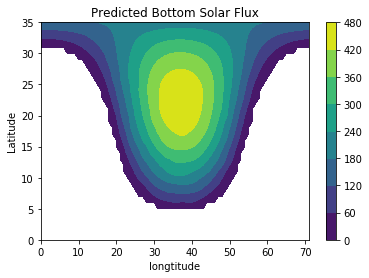

<Figure size 432x288 with 0 Axes>

In [31]:
plt.contourf(full_pred_contour)
plt.colorbar()
plt.title("Predicted Bottom Solar Flux")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig("Predicted")

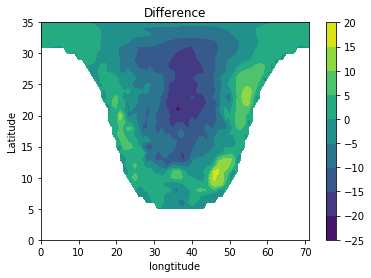

In [32]:
plt.contourf(full_pred_contour - full_out_contour)
plt.colorbar()
plt.title("Difference")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()

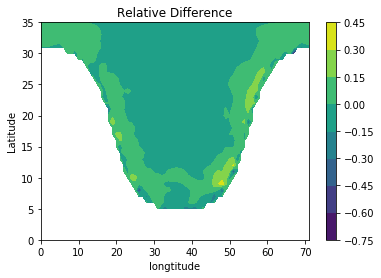

In [33]:
plt.contourf((full_pred_contour - full_out_contour)/full_out_contour)
plt.colorbar()
plt.title("Relative Difference")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()